In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-datasets/daily-minimum-temperatures-in-me.csv
/kaggle/input/time-series-datasets/sales-of-shampoo-over-a-three-ye.csv
/kaggle/input/time-series-datasets/Electric_Production.csv
/kaggle/input/time-series-datasets/monthly-beer-production-in-austr.csv


In this problem statement we r only going to solve Electric_Production.csv

In [13]:

from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')
import pmdarima as pm

In [14]:
df=pd.read_csv("/kaggle/input/time-series-datasets/Electric_Production.csv")

In [15]:
df=df.rename(columns={'IPG2211A2N':'Production'})

In [16]:
df.dtypes

DATE           object
Production    float64
dtype: object

we r gonna solve time series problem

step1:we clearly see dtype of column DATE is object,we have to convert it into DATETIME

step2:we have to remove the index,and made DATE as index

In [17]:
df["DATE"]=pd.to_datetime(df["DATE"],infer_datetime_format=True)

In [18]:
df=df.set_index(['DATE'])
df.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
df.index.min()

# Lets visulize our data(before that we should understand following terms)

# Trend

1-The increasing or decreasing value in the series

2-we can take example of facebook

3-Number of facebook users is increasing with time,so its a trend

4-Number of people who uses Yahoo as their search engine are deacreasing,its also a trend but a decreasing trend

5-Mathematical Curve-it can be linear or damped or exponential

# Seasonality

2-Lets understand by taking an example of icecream

3-We all eats ice-cream mostly in summers

4-Therefore the sales of icecreams is increases mostly in summers and then drop down in winter(that what we called seasonality)

5-Mathematics curve-its mostly of a sin curve or a distorted sin curve

# Trend with seasonality


1-we can take example of ice cream sales

2-World population is increasing every year(so its  trend)

3-In summers ice creams sells more than winter(its a seasonality)

4-so we can say that as time increasing ice cream sales also increasing because buyers are increasing and in summers it increases more due to seasonality effect

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6
df.plot()

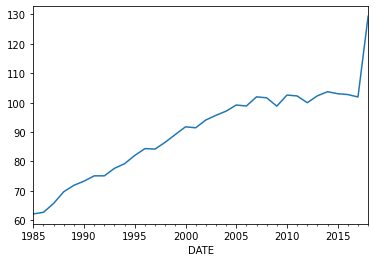

In [19]:
annual_prod = df['Production'].resample('A').mean()
annual_prod.plot()

We clearly see that their is an increasing trend and seasonality

Now we will decompose the above visulization into trend and seasonality for more clear visulization

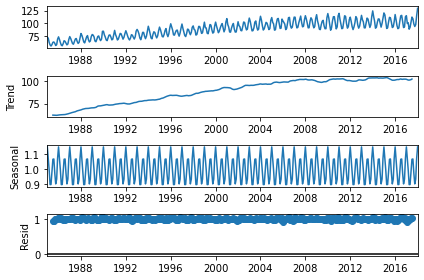

In [20]:

from statsmodels.tsa.seasonal import seasonal_decompose
res= seasonal_decompose(df, model='multiplicative')
res.plot()
plt.show()

Residual means Noise

In [21]:
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -7.104891e+00
p-value                 4.077787e-10
Lags Used               1.400000e+01
Observations Used       3.810000e+02
Critical Value (1%)    -3.447631e+00
Critical Value (5%)    -2.869156e+00
Critical Value (10%)   -2.570827e+00
dtype: float64


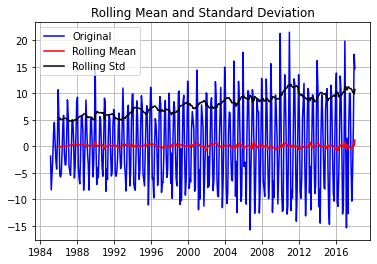

In [26]:
dftest(df.Production.diff()[1:])

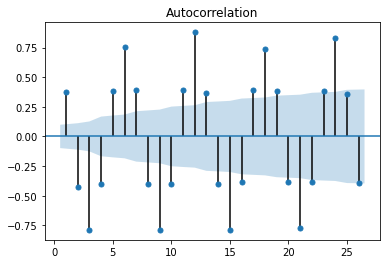

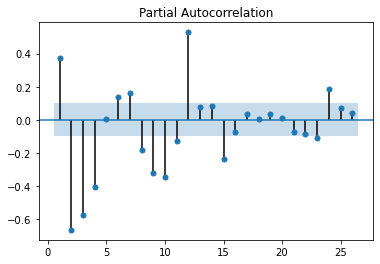

In [28]:
sm.tsa.graphics.plot_acf(df.Production.diff()[1:],zero=False)
sm.tsa.graphics.plot_pacf(df.Production.diff()[1:],zero = False);

We clearly see their is a increasing trend

Lets see the first 60 value of our data to understand seasonality more visually

In [ ]:
train["IPG2211A2N"].iloc[:60]

U can  also see that after every year at January the electric production increases

so we can say that its a yearly seasonality

# STEP3-REMOVE TREND TO MADE DATA STATIONARY

# STATIONARITY

1-Data didnt have any trend and seasonality

2-In practical sense electric production is not increasing with time it is constant its does not have any seasonality effect

3-Why requires?Just like data needs to be normalized,features needs to be scaled before sending to ML algorithms,similarly time series algorithms wants data to be stationary

4-Mathematically-Means should be constant,standard deviation should be constant,auto-correlation should be same

5-we r going to check it using adfuller test(p-value will be used as a distinguisher (if p-value>0.05=Non-Stationary,if p-value<0.05=Stationary)

Lets do adfuller on our dataset

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def stest(x):
    result = adfuller(x)
    print(result[1])

In [ ]:
stest(train.iloc[:,0].values)

0.18621>0.05 data is non stationary

Lets make it stationary

we will use differencing method for removing trend and seasonality

For eg.:
if our data is like:[1,2,3,4,5,6,7,8,9]

If we subtract each two adjacent digit then our data will be:[2-1,4-3,5-4,6-5,7-6,8-7,9-8]:[1,1,1,1,1,1,1,1...]

Point to remember:Removing trend didnot mean that we should make the value constant for whole interval,it only means that the MEAN should be same for sub-interval in a interval

In [ ]:
len(train)


In [24]:
a=[]
a.append(df["Production"].iloc[0])
for i in range(396):  # for all the values in the dataset
     df["Production"]=df["Production"].iloc[i+1]-df["Production"].iloc[i]
     a.append(z)

In [25]:
a[:5]

[72.5052, -1.833200000000005, -8.221799999999995, -4.9788, -2.1563000000000017]

In [ ]:
plt.plot(a)

Now lets go for adfuller test

In [ ]:
stest(a)

0.0003875068

clearly 0.05>0.0003875068

Our Data is Stationary

In [ ]:
t=train["IPG2211A2N"].to_dict()
x={}
l=0
for i,j in t.items():
       x.update({i:a[l]})
       l=l+1
   

In [ ]:
xe=pd.Series(x)

In [ ]:
plt.plot(xe)

# ARIMA

ARIMA-{AutoRegression}{Integrated}{Moving Average}

Auto Regression=It simply means values at present time is dependent on which-which previous time instant

m(t)=Am(t-1)+Bm(t-3)+Cm(t-4)+....

In above eg. m(t) is present time and it clearly depends on lag of 1,lag of 3,lag of 4 time instant

PACF=Partial auto correlation value is used to calculate AR value(when line is above blue region we will count those value and total will be our AR value for our ARIMA model)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot=plot_pacf(xe,lags=10)

> AR=3(most significant values)

Moving Average=It is calculated using Autocorrelation (when the line goes above blue region we will count them all the total will be our MA)

In [ ]:
acf_plot=plot_acf(xe,lags=10)

we are counting most significant line MA=3)

Train/Test Split

In [ ]:
len(xe)

In [ ]:
xtrain=xe[0:330]
xtest=xe[330:397]

In [ ]:
len(xtrain)

In [ ]:
xtrain.head()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
xee=ARIMA(xtrain,order=(3,0,3))

In [ ]:
ttt=xee.fit()

In [ ]:
ttt.aic

In [ ]:
tt=ttt.forecast(steps=67)[0]

In [ ]:
tt[:10]

In [ ]:
xtest.values[:10]

In [ ]:
xtest.size

Lets compare our forecasted value but before that we have to convert those forecast value to their original format(to remove trend we have subtracted one value from other now we have to reverse that process to get original value back)

In [ ]:
xtest[0]

In [ ]:
qqq=[]
a=0
for i in range(330):
    a=a+xtrain[i]
    qqq.append(a)

In [ ]:
train["IPG2211A2N"].iloc[335]

In [ ]:
qqq[329]

Great qqq[329]=101.14 we will use this value to find our forecast value and xtest value

In [ ]:
def pv(web):
        qqq=[]
        a=101.4
        for i in range(67):
            a=a+web[i]
            qqq.append(a)
        return qqq

In [ ]:

qqqt=pv(xtest)

In [ ]:
qqqt[:10]

In [ ]:
qqqf=pv(tt)

In [ ]:
qqqf[:5]

qqqt is our test data and qqqf is our forecast data now we are going to check accuracy using root mean squared error

In [ ]:
from sklearn.metrics import mean_squared_error 
import numpy as np

In [ ]:
error=mean_squared_error(qqqt,qqqf)

In [ ]:
error

In [ ]:
np.sqrt(error)

Great our model is performing good with just a 5% error

# If u like this notebook plz UpVote it